In [1]:
%matplotlib inline
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm

from agent import model
from agent import dhp as DHP

2023-09-29 12:45:06.220129: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-29 12:45:06.303478: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-29 12:45:06.304563: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-29 12:45:07.767409: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def reference_state(current_state):
    y_pos = current_state[1]
    if y_pos > 0.75:
        ref_state = [0, 0.75, 0, -0.25, 0, 0, 0, 0]
    else:
        ref_state = [0, 0, 0, -0.1, 0, 0, 0, 0]
    return ref_state

# Example of Controlling LunarLander v2
Observation space:
[x, y, V_x, V_y, angle, angular velocity, left leg contact, right leg contact]

In [3]:
env = gym.make(
    "LunarLander-v2", continuous = True
)
init_condition = env.reset()
state_size = len(init_condition)
action_size = int(env.action_space.shape[0])

X, U, R, errors = [], [], [], []
t0 = 0
tn = 30
dt = 0.01
t = np.arange(t0, tn, dt)

# run single episode
for i in range(1,len(t)):
    action = [0.1,-0.6]
    state, reward, done, _, _= env.step(action)
    X.append(state)
    U.append(action)
    R.append(reward)
    errors.append(np.abs(state - reference_state(state)))
    env.render()
    if done: 
        t = t[:i]
        break
action_size

c:\Users\Labra\miniconda3\envs\tf_GPU\lib\site-packages\gymnasium\envs\box2d\lunar_lander.py:681: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("LunarLander-v2", render_mode="rgb_array")
  gym.logger.warn(


2

## Plotting

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


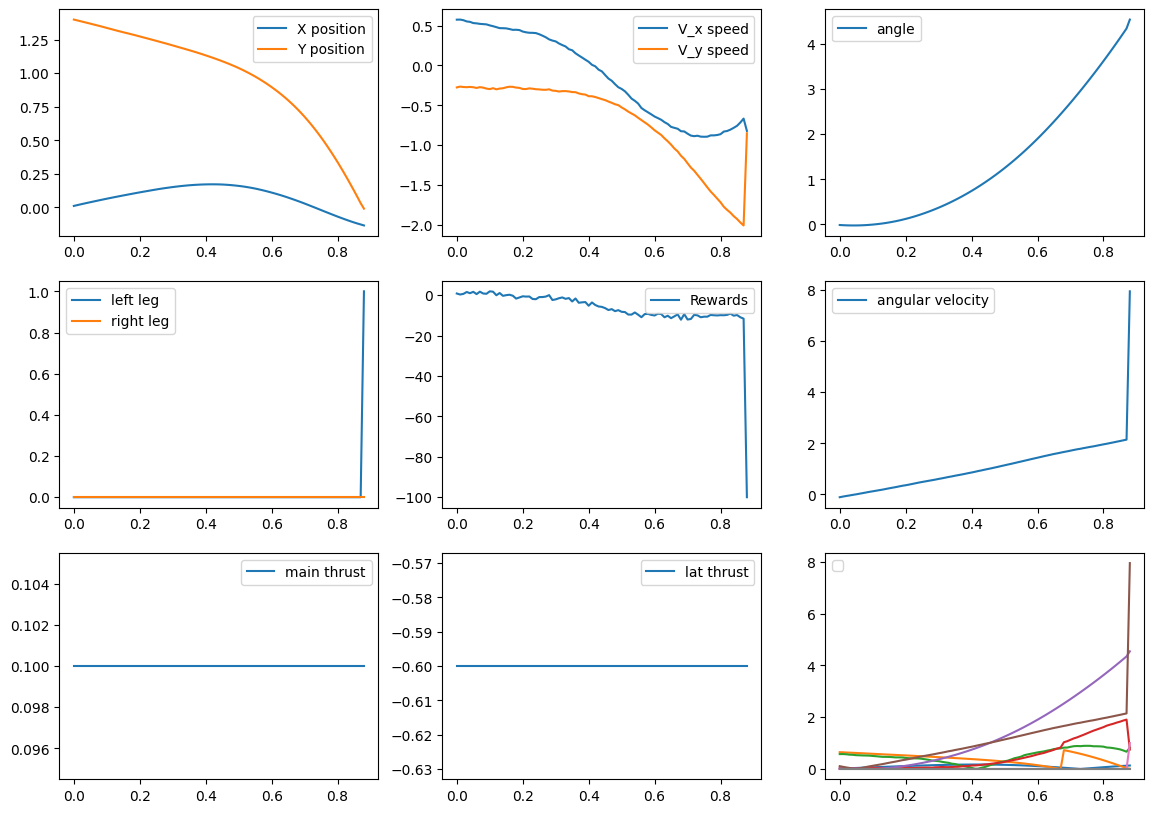

In [4]:
fig, axis = plt.subplots(3,3, figsize=(14,10))
axis[0, 0].plot(t, [i[0] for i in X], label="X position")
axis[0, 0].plot(t, [i[1] for i in X], label="Y position")
axis[0, 0].legend()

axis[0, 1].plot(t, [i[2] for i in X], label="V_x speed")
axis[0, 1].plot(t, [i[3] for i in X], label="V_y speed")
axis[0, 1].legend()

axis[0,2].plot(t, [i[4] for i in X], label="angle")
axis[0,2].legend()

axis[1,2].plot(t, [i[5] for i in X], label="angular velocity")
axis[1,2].legend()

axis[1,0].plot(t, [i[6] for i in X], label="left leg")
axis[1,0].plot(t, [i[7] for i in X], label="right leg")
axis[1,0].legend()

axis[1,1].plot(t, R, label="Rewards")
axis[1,1].legend()

axis[2,0].plot(t, [i[0] for i in U], label="main thrust")
axis[2,0].legend()
axis[2,1].plot(t, [i[1] for i in U], label="lat thrust")
axis[2,1].legend()

axis[2,2].plot(t, errors)
axis[2,2].legend()


# DHP LunarLander

In [12]:
TENSORBOARD_DIR = './logs/tensorboard/DHP/'

env = gym.make(
    "LunarLander-v2", continuous = True
)
init_condition = env.reset()[0]
state_size = len(init_condition)
action_size = int(env.action_space.shape[0])
TRACKED = [True for i in init_condition]

STATE_ERROR_WEIGHTS = [0, 1, 1, 1, 1, 1, 0, 0]
lr_critic = 0.1
lr_actor = 0.05
gamma_actor = 0.4

ac_kwargs = {
        # Arguments for all model types
        'state_size': state_size,
        'action_size': action_size,
        'predict_delta': False,
        # Neural Network specific args:
        'hidden_layer_size': [100, 100, 100],
        'activation': tf.nn.relu,
        # RLS specific args:
        'gamma': 0.9995,
        'covariance': 100,
        'constant': True,
        # LS specific args:
        'buffer_length': 10
}
ac_model = model.RecursiveLeastSquares(**ac_kwargs)

kwargs = {
    'input_size': [state_size, state_size],                     # [Aircraft state size, Number of tracked states]
    'output_size': action_size,                                         # Actor output size (Critic output is dependend only on aircraft state size)
    'hidden_layer_size': [50, 50, 50],                                    # List with number of nodes per layer, number of layers is variable
    'kernel_stddev': 0.1,                                               # Standard deviation used in the truncated normal distribution to initialize all parameters
    'lr_critic': lr_critic,                                                   # Learn rate Critic
    'lr_actor': lr_actor,                                                   # Learn rate Actor
    'gamma': gamma_actor,                                                       # Discount factor
    'use_bias': False,                                                  # Use bias terms (only if you train using batched data)
    'split': False,                                                      # Split architechture of the actor, if False, a single fully connected layer is used.
    'target_network': False,                                             # Use target networks 
    'activation': tf.keras.layers.Activation('relu'),
    'log_dir': TENSORBOARD_DIR,                                         # Where to save checkpoints
    'use_delta': (True, TRACKED)                                       # (True, TRACKED) used 's = [x, (x - x_ref)]' || (False, None) uses 's = [x, x_ref]' 
}
agent = DHP.Agent(**kwargs) 
# todo continue actor and critic breakdown

Critic Network build.
Actor network build.


In [13]:
X, U, R, C_real= [], [], [], []
X_pred, C_trained, action_grad, critic_grad = [], [], [], [] 
list_F, list_G, list_RLS_cov, e_model = [], [], [], []
U_ref = []
episode_counter = 0
max_episode = 5 
max_steps = 300
with tqdm(range(max_episode)) as tqdm_it:
    for i in tqdm_it:
        print(f"episode: {i}")
        # init params 
        init_condition = env.reset()[0]
        ac_model.reset()
        x = init_condition
        P = np.diag(TRACKED).astype(float)
        Q = np.diag(STATE_ERROR_WEIGHTS)
        X.append(init_condition)
        done = False
        steps = 1
        while not done and steps < max_steps:
            x_ref = reference_state(x)
            R_sig = np.array(x_ref).reshape([1, -1, 1])
            U_ref.append(R_sig)
            j = 0
            x = x.reshape([1, -1, 1]) 
            while j < 2: 
                # Next state prediction
                action = np.squeeze(agent.action(x, reference = R_sig))
                action_clipped = np.clip(action, np.array([0, -1]), np.array([1, 1]))
                x_next_pred = ac_model.predict(x, action_clipped).reshape([1, -1, 1])

                if np.isnan(x_next_pred).any():
                    done = True
                    print("="*8, i, j, "="*8)
                    print(f"{x_next_pred = }\n{action =}\n{R_sig = }\n{x =}")
                    print("="*20)
                    episode_counter += 1
                # Cost prediction
                e = np.matmul(P, x_next_pred - R_sig) 
                cost = np.matmul(np.matmul(e.transpose(0,2,1), Q), e)
                dcostdx = np.matmul(2*np.matmul(e.transpose(0,2,1), Q), P)

                dactiondx       = agent.gradient_actor(x, reference = R_sig)
                lmbda           = agent.value_derivative(x, reference = R_sig)
                # Critic
                target_lmbda    = agent.target_value_derivative(x_next_pred, reference = R_sig)
                A               = ac_model.gradient_state(x, action)
                B               = ac_model.gradient_action(x, action)
                # print(f"|ITER {i}||{j}| Values before grad_critic:\n{lmbda =}\n{dcostdx = }\n{agent.gamma =}\n{target_lmbda =}\n{A =}\n{B = }\n{dactiondx =}")
                grad_critic     = lmbda - np.matmul(dcostdx + agent.gamma*target_lmbda, A + np.matmul(B, dactiondx))
                grad_critic     = np.clip(grad_critic, -0.2, 0.2)
                # print(f"TOTAL GRAD CRITIC = {grad_critic}")

                agent.update_critic(x, reference = R_sig, gradient = grad_critic, learn_rate=lr_critic)
                # Actor
                lmbda       = agent.value_derivative(x_next_pred, reference = R_sig)
                grad_actor  = np.matmul(dcostdx + agent.gamma*lmbda, B)
                # print(f"TOTAL GRAD ACTOR = {grad_actor}")
#                grad_actor  = np.clip(grad_actor, -0.1, 0.1)
                # grad_actor  = utils.overactuation_gradient_correction(gradients=grad_actor, actions=action, actions_clipped=action_clipped)
                agent.update_actor(x, reference = R_sig, gradient = grad_actor, learn_rate=lr_actor)
                j += 1

            X_pred.append(x_next_pred)
            C_trained.append(cost.flatten())
            action_grad.append(grad_actor)
            critic_grad.append(grad_critic)
            list_F.append(A.flatten().copy())
            list_G.append(B.flatten().copy())
            list_RLS_cov.append(ac_model.cov.copy())

            ### Run environment ###
            action      = agent.action(x, reference = R_sig)
            action = np.clip(action, np.array([0, -1]), np.array([1, 1]))
    #        if i < 1000: # TODO: take some contrained controls 
    #            action += excitation[:,i].reshape(action.shape)
            x_next, reward, _, _, _ = env.step(np.squeeze(action))
            steps += 1
            model_error = ((x_next_pred - x_next)**2).mean()

            ### Real Cost ###
            e = np.matmul(P, (x_next - x_ref))
            cost = np.matmul(np.matmul(e, Q), e)

            R.append(reward)
            X.append(x_next)
            U.append(np.squeeze(action))
            e_model.append(model_error)
            C_real.append(cost)

            ### Update Model ###
            ac_model.update(x, action, x_next)

            ### Bookkeeping ###
            x = x_next
            if x_next[-1] or x_next[-2]: # break loop when legs are touching ground  
                done = True
                episode_counter += 1
                print("DONE")

  0%|                                                                         | 0/5 [00:00<?, ?it/s]

episode: 0
|ITER 0||0| Values before grad_critic:
lmbda =array([[[-0.01578251,  0.01183544, -0.01234645, -0.04594475,
          0.02580698,  0.02000687,  0.00919324, -0.0052989 ]]],
      dtype=float32)
dcostdx = array([[[ 0. , -1.5,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ]]])
agent.gamma =0.4
target_lmbda =array([[[ 0.00114892,  0.00484787, -0.00215083, -0.00110762,
          0.00658336,  0.00534426,  0.00123594, -0.01042988]]],
      dtype=float32)
A =array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])
B = array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])
dactiondx =array([[[-2.9478088e-02,  3.8326466e-03, -2.2839904e-02,  1.393143

/tmp/ipykernel_3683729/3085331624.py:50: RuntimeWarning: invalid value encountered in matmul
  grad_critic     = lmbda - np.matmul(dcostdx + agent.gamma*target_lmbda, A + np.matmul(B, dactiondx))
 20%|█████████████                                                    | 1/5 [00:05<00:20,  5.11s/it]

|ITER 0||1| Values before grad_critic:
lmbda =array([[[-1.5843016 , -1.1797856 , -0.56549716, -1.0956664 ,
          0.5328826 ,  0.24473469,  0.03093201, -0.13120759]]],
      dtype=float32)
dcostdx = array([[[  0.        , -11.76352575,  -3.82438172,  -8.08856405,
           4.66416174,   1.04011921,   0.        ,   0.        ]]])
agent.gamma =0.4
target_lmbda =array([[[-1.6018354 , -1.1929057 , -0.571758  , -1.1077758 ,
          0.53896374,  0.24726674,  0.03132333, -0.13272466]]],
      dtype=float32)
A =array([[ 8.67075611e-01,  1.44687531e-02,  6.93874133e-02,
         4.88727666e-02, -3.48187412e-02,  9.53216554e-03,
         0.00000000e+00,  0.00000000e+00],
       [ 1.50586452e-02,  9.96254172e-01, -5.58782238e-03,
         2.24739360e-02,  9.33817039e-03, -5.76536029e-04,
         0.00000000e+00,  0.00000000e+00],
       [ 1.35736752e-01,  6.72836070e-03,  9.41709110e-01,
        -1.04820594e-01, -5.94928382e-03, -6.68066725e-03,
         0.00000000e+00,  0.00000000e+00],
  

100%|█████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.04s/it]

TOTAL GRAD ACTOR = [[[nan nan]]]
episode: 3
======== 3 0 ========
x_next_pred = array([[[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]]])
action =array([nan, nan])
R_sig = array([[[ 0.  ],
        [ 0.75],
        [ 0.  ],
        [-0.25],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ]]])
x =array([[[-0.00346527],
        [ 1.3990918 ],
        [-0.3509962 ],
        [-0.52571076],
        [ 0.00402202],
        [ 0.07950585],
        [ 0.        ],
        [ 0.        ]]], dtype=float32)
|ITER 3||0| Values before grad_critic:
lmbda =array([[[0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=float32)
dcostdx = array([[[nan, nan, nan, nan, nan, nan, nan, nan]]])
agent.gamma =0.4
target_lmbda =array([[[0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=float32)
A =array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]

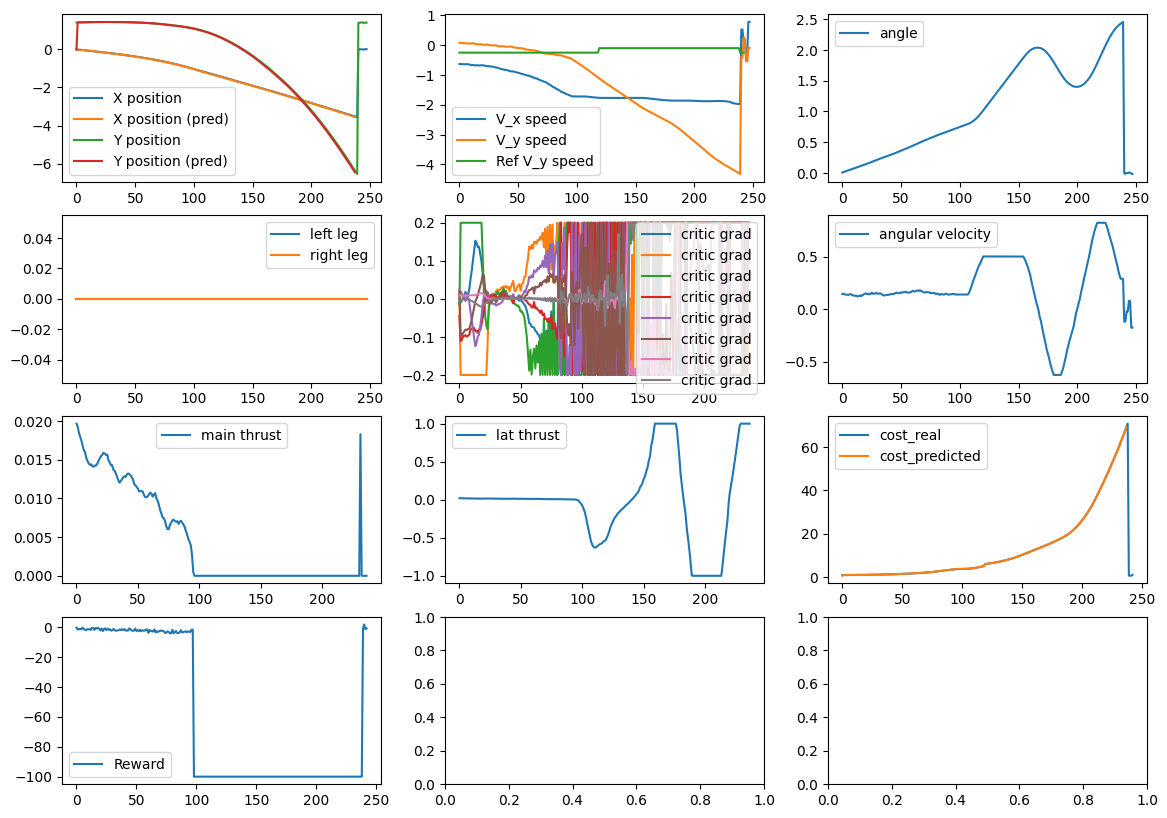

In [14]:
fig, axis = plt.subplots(4,3, figsize=(14,10))
axis[0, 0].plot([i[0] for i in X], label="X position")
axis[0, 0].plot([np.squeeze(i)[0] for i in X_pred], label="X position (pred)")
axis[0, 0].plot([i[1] for i in X], label="Y position")
axis[0, 0].plot([np.squeeze(i)[1] for i in X_pred], label="Y position (pred)")
axis[0, 0].legend()

axis[0, 1].plot([i[2] for i in X], label="V_x speed")
axis[0, 1].plot([i[3] for i in X], label="V_y speed")
axis[0, 1].plot([np.squeeze(i)[3] for i in U_ref], label="Ref V_y speed")
axis[0, 1].legend()

axis[1, 1].plot([np.squeeze(i) for i in critic_grad], label="critic grad")
axis[1, 1].legend()


axis[0,2].plot([i[4] for i in X], label="angle")
axis[0,2].legend()

axis[1,2].plot([i[5] for i in X], label="angular velocity")
axis[1,2].legend()

axis[1,0].plot([i[6] for i in X], label="left leg")
axis[1,0].plot([i[7] for i in X], label="right leg")
axis[1,0].legend()

axis[2,0].plot([i[0] for i in U], label="main thrust")
axis[2,0].legend()
axis[2,1].plot([i[1] for i in U], label="lat thrust")
axis[2,1].legend()

axis[2,2].plot(C_real, label="cost_real")
axis[2,2].plot(C_trained, label="cost_predicted")
axis[2,2].legend()

axis[3,0].plot(R, label="Reward")
axis[3,0].legend()